<h1 style = "text-align:center">Détection du mildiou de la pomme de terre par imagerie grâce aux méthodes de Machine Learning</h1>

---

# Importation des packages

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import os

import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


# Jeu de données

##Importation

In [2]:
# Definition des constantes pour l'importation des images

size = 256
batch_size = 32

# connecter le drive afin d'accéder aux données
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Définition du chemin d'accès
dataset_dir = '/content/drive/MyDrive/PlantVillage' #dossier global
classe_dir = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy'] #dossiers des classes
classe_label = ['Mildiou précoce', 'Mildiou tardif', 'Sain'] # Définition des labels pour les classes

# Importation
data = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    shuffle=True,
    image_size=(size, size),
    batch_size=batch_size
)


Found 2152 files belonging to 3 classes.


Nous avons 2152 images dans ce jeu de données

## Description

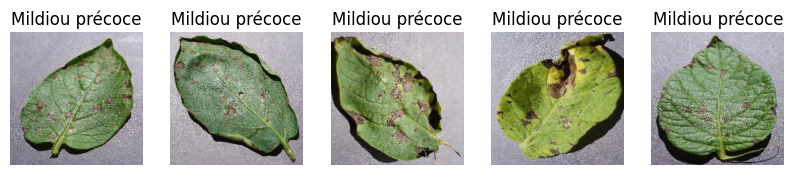

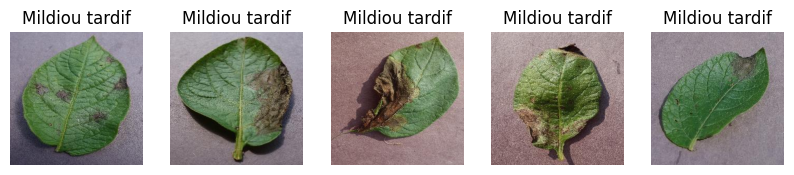

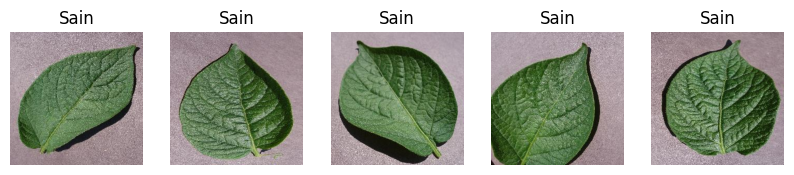

In [4]:
# Visualisation d'un échantillon d'images pour chaque classes

for k in range(3):
  plt.figure(figsize=(10,10))
  classe = classe_dir[k]
  os.listdir(dataset_dir + '/' + classe)[:5]
  for i in range(5):
    plt.subplot(5,5,i+1)
    plt.imshow(Image.open(dataset_dir + '/' + classe + '/' + os.listdir(dataset_dir + '/' + classe)[i]))
    plt.axis('off')
    plt.title(classe_label[k])
plt.show()


**Les images sont-elles réparties de manière équitable parmi les 3 classes ?**

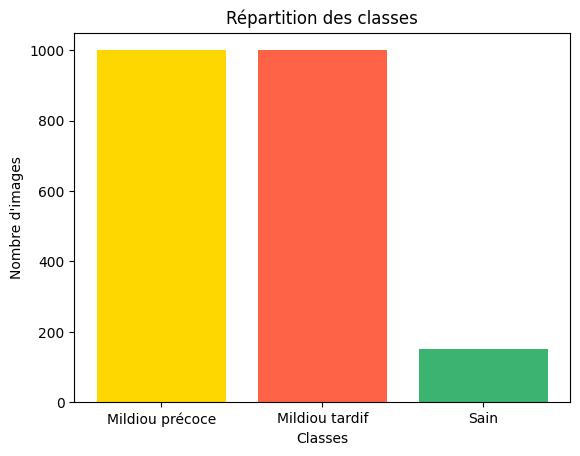

In [5]:
# Compte par classe
count = []
for classe in classe_dir:
    count.append(len(os.listdir(dataset_dir + '/' + classe)))

# création d'un barplot
plt.bar(classe_label, count, color = ['gold','tomato','mediumseagreen'])
plt.title('Répartition des classes')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.show()

On observe un déséquilibre important des classes dans le jeu de données entre les classes "malade" et la classe sain. Ce déséquilibre peut entraîner un biais important dans notre modèle. Pour y palier nous utilisons donc la technique de suréchantillonage de la classe minoritaire (Technique SMOTE).


# Prétraitement des images


*   redimensionnement des images en (150*150) avec 3 canaux de couleur
*   Donnés applaties en un tableau 1D



In [6]:
target = []
flat_data_arr = []
for label, i in enumerate(classe_dir):
  print("loading category : {", i, "}")
  path = os.path.join(dataset_dir,i)
  for j in os.listdir(path):
    img_array = imread(os.path.join(path,j))
    img_resize = resize(img_array,(150,150,3))
    #flat_data_arr = img_resize.flatten()
    flat_data_arr.append(img_resize.flatten())
    target.append(label)
  print(f"loaded category:{i} successfully")
flat_data = np.array(flat_data_arr)
target = np.array(target)

loading category : { Potato___Early_blight }
loaded category:Potato___Early_blight successfully
loading category : { Potato___Late_blight }
loaded category:Potato___Late_blight successfully
loading category : { Potato___healthy }
loaded category:Potato___healthy successfully


In [7]:
print(target.shape)
print(flat_data.shape)

(2152,)
(2152, 67500)


## Données converties en DataFrame puis divisé en x et y

In [8]:
df2 = pd.DataFrame(flat_data)
df2['Target'] = target
x=df2.iloc[:,:-1]
y=df2.iloc[:,-1]

## Division des données pour l'entrainement et le test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42) #reproductibilité

## Application de la technique SMOTE

In [10]:
smote = SMOTE(sampling_strategy='minority',  #  équilibrer la classe minoritaire
              random_state=42) # reproductibilité
X_train, y_train = smote.fit_resample(X_train, y_train)


Main

(2410, 67500)
(2410,)
[[  0 804]
 [  1 802]
 [  2 804]]


Text(0, 0.5, "Nombre d'images")

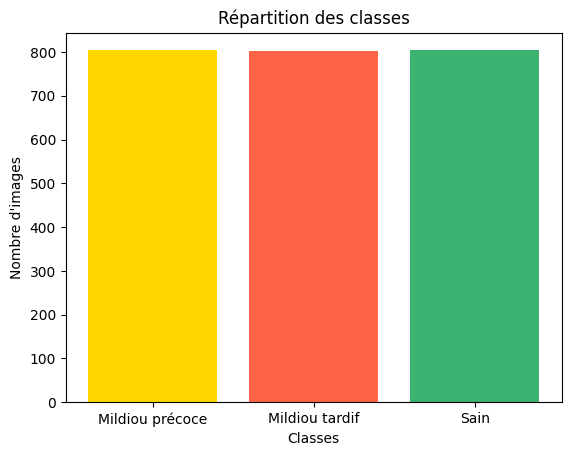

In [11]:
# taille du jeu de données d'entrainement
print(X_train.shape)
print(y_train.shape)

# répartition des classes dans le jeu de données d'entrainement
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

# barplot
plt.bar(classe_label, counts, color = ['gold','tomato','mediumseagreen'])
plt.title('Répartition des classes')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')

Maintenant que le jeu de données est prétraité, on applique plusieurs modèle de classification sur le jeu d'entrainement

# KNN

In [ ]:
# Définir le modèle KNN
knn = KNeighborsClassifier()

# Définir les paramètres à tester
param_grid = {
    'n_neighbors': np.arange(1, 21, 2),  # Tester les valeurs impaires de 1 à 10
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Tester différentes métriques
}

# Créer un GridSearchCV
grid_search = GridSearchCV(knn,
                           param_grid,
                           cv=5,
                           scoring='accuracy',
                           verbose=1)

# Ajuster le modèle avec les données d'entraînement
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres : ", grid_search.best_params_)
print("Meilleure précision : ", grid_search.best_score_)

# Utiliser le meilleur modèle pour prédire sur l'ensemble de validation
best_knn = grid_search.best_estimator_
y_test_pred = best_knn.predict(X_test)

# Évaluer le modèle
print("\nRapport de classification :\n", classification_report(y_test, y_test_pred))
print("\nMatrice de confusion :\n", confusion_matrix(y_test, y_test_pred))

#Fitting 5 folds for each of 15 candidates, totalling 75 fits
#/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
#  _data = np.array(data, dtype=dtype, copy=copy,
#Meilleurs paramètres :  {'metric': 'manhattan', 'n_neighbors': 1}
#Meilleure précision :  0.7889753700505999
##
##Rapport de classification :
#               precision    recall  f1-score   support
#
#           0       0.99      0.62      0.76       196
#           1       0.70      0.79      0.74       198
#           2       0.31      0.73      0.44        37
#
#    accuracy                           0.71       431
#   macro avg       0.67      0.71      0.65       431
#weighted avg       0.80      0.71      0.72       431
#
#
#Matrice de confusion :
# [[121  57  18]
# [  0 156  42]
# [  1   9  27]]

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [ ]:
# Évaluer le modèle
print("\nRapport de classification :\n", classification_report(y_test, y_test_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classe_label)
disp.plot(cmap=plt.cm.Blues)
plt.show()